In [1]:
# execute locally to include figures
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from matplotlib import gridspec
from scipy.signal import find_peaks


plt.rcParams.update({'font.size': 8})

def label_subplots_ABC(fig, axs, x_shift, y_shift, start_idx=0, **text_kws):
    labels = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'][start_idx:]
    if type(x_shift) != list():
        x_shift = [x_shift] * len(axs)
    if type(y_shift) != list():
        y_shift = [y_shift] * len(axs)
    for i, ax in enumerate(axs):
        # Get the position of the subplot
        pos = ax.get_position()  # returns (left, bottom, width, height)

        # Annotate at the upper-left corner of each subplot
        fig.text(pos.x0 + x_shift[i], pos.y1 + y_shift[i], labels[i], **text_kws)   

   
def divide_with_uncertainty(numerator_mean, numerator_sem, 
                             denom1_mean, denom1_sem, 
                             denom2_mean, denom2_sem):
    # Step 1: Compute combined denominator mean
    denom_mean = (denom1_mean + denom2_mean) / 2

    # Step 2: Compute combined denominator SEM
    denom_sem = np.sqrt((denom1_sem**2 + denom2_sem**2) / 4)

    # Step 3: Division and uncertainty propagation
    result = numerator_mean / denom_mean
    rel_uncertainty = np.sqrt((numerator_sem / numerator_mean)**2 +
                              (denom_sem / denom_mean)**2)
    result_sem = result * rel_uncertainty

    return result, result_sem

def min_to_avg_max_ratio(curve, curve_sem):
    curve = np.array(curve)
    # Find local maxima
    peaks, _ = find_peaks(curve)
    if len(peaks) < 2:
        raise ValueError("Less than two maxima found.")
    # Keep only the two highest maxima
    peak_vals = curve[peaks]
    top_two_indices = peaks[np.argsort(peak_vals)[-2:]]
    top_two_indices.sort()  # ensure left to right
    # Find the minimum between the two maxima
    min_index = np.argmin(curve[top_two_indices[0]:top_two_indices[1]+1])
    min_val = curve[top_two_indices[0] + min_index]
    min_sem = curve_sem[top_two_indices[0] + min_index]
    max1, max2 = curve[top_two_indices]
    max1_sem, max2_sem = curve_sem[top_two_indices]
    res, res_sem = divide_with_uncertainty(
        numerator_mean=min_val, numerator_sem=min_sem, 
        denom1_mean=max1, denom1_sem=max1_sem, 
        denom2_mean=max2, denom2_sem=max2_sem
    )
    return res, res_sem

In [2]:
labels=['morph.1', 'morph.2', 'point']
stim_dist_max_idx = 6
stim_dist =np.array([0, 100, 200, 300, 400, 500, 600, 900, 1200, 1500])[:stim_dist_max_idx]
dx = 0.05 #mm
x = np.arange(-2,2,dx) #mm
fr_mean = np.load('network_data/numpy_arrays/dual_stim_mean.npy')[:,:stim_dist_max_idx,:]
fr_sem = np.load('network_data/numpy_arrays/dual_stim_sem.npy')[:,:stim_dist_max_idx,:]

# input to single neuron
cu_mean_d100um = [np.load(''.join(['network_data/numpy_arrays/', l, '_current_mean.npy']))[0] for l in ['morph_1','morph_2','no_morph']]
dx_cu = 2 #um
dt_cu = 1 #ms
stim_on_time_idx = int(0 / dt_cu)
stim_off_time_idx = int(100 / dt_cu) # ms
cu_tmean = [cu_label[stim_on_time_idx:stim_off_time_idx].mean(axis=0) for cu_label in cu_mean_d100um]

# calculate rel. firing response at minimum
#rel_min_vals = dict()
#for i, l in enumerate(labels):
#    rel_min_vals[l]= []
#    for j, dist in enumerate(stim_dist[2:]):
#        j+=2
#        rel_min_vals[l].append(min_to_avg_max_ratio(curve=fr_mean[i][j]))
rel_min_vals = dict()
rel_min_sems = dict()
separation_start_idx = 2 # starts at 200, which is 3rd entry
for i, l in enumerate(labels):
    rel_min_vals[l]= []
    rel_min_sems[l]= []
    for j, dist in enumerate(stim_dist[separation_start_idx:]):
        j+=separation_start_idx
        val, sem = min_to_avg_max_ratio(curve=fr_mean[i][j], curve_sem=fr_sem[i][j])
        rel_min_vals[l].append(val)
        rel_min_sems[l].append(sem)

In [3]:
minima = np.array([[13.13131313,  5.11111111,  2.92063492,  2.66666667,  2.86111111,
         1.06349206,  1.01010101,  0.58585859],
       [19.6969697 ,  7.41269841,  3.74603175,  2.20634921,  2.13888889,
         1.33333333,  0.68253968,  0.57777778],
       [26.08080808, 15.41414141,  6.66666667,  4.59259259,  3.75      ,
         1.65079365,  0.7037037 ,  0.8       ]])
sems = np.array([[2.85470085, 2.71604938, 1.7962963 , 1.94444444, 2.34567901,
        1.71428571, 2.04761905, 1.95238095],
       [2.41025641, 2.33333333, 2.16666667, 2.22222222, 1.45679012,
        1.97530864, 1.85858586, 3.24444444],
       [2.97435897, 2.49382716, 2.35185185, 1.82222222, 1.60493827,
        1.17948718, 2.3030303 , 3.22222222]])
coords = np.array([ 200,  300,  400,  500,  600,  900, 1200, 1500])

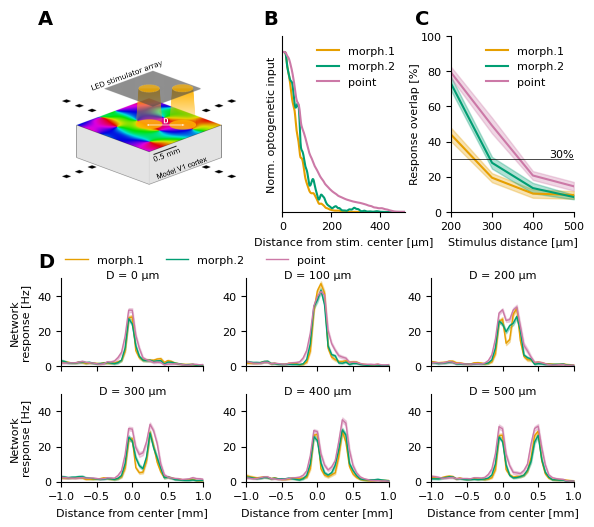

In [4]:
a4_w, a4_h = 8.27, 11.69
fig = plt.figure(figsize=(a4_w*0.8, a4_w*0.7))

colors = ['#E69F00', '#009E73', '#CC79A7']

# Outer grid: 3 rows, 1 column
outer = gridspec.GridSpec(4, 1, height_ratios=[1.5, 0.1, 0.75, 0.75], hspace=0.3)

# Row 1: 2 columns
row1 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer[0], wspace=0.33, width_ratios=[1,0.7,0.7])
ax1 = fig.add_subplot(row1[0])
ax2 = fig.add_subplot(row1[2])
ax2a = fig.add_subplot(row1[1])

# Row 2: 3 columns
row2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer[2], wspace=0.3)
ax3 = fig.add_subplot(row2[0])
ax4 = fig.add_subplot(row2[1])
ax5 = fig.add_subplot(row2[2])

# Row 3: 3 columns (after a thinner spacer row)
row3 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer[3], wspace=0.3)
ax6 = fig.add_subplot(row3[0])
ax7 = fig.add_subplot(row3[1])
ax8 = fig.add_subplot(row3[2])

# import sketch
ax1.axis('off')
ax1.imshow(mpimg.imread('/home/david/Documents/papers/reduction_paper/two_stimulator_model.png'))

for l, c, cu_tmean_label in zip(labels, colors, cu_tmean):
    ax2a.plot(np.arange(0,len(cu_tmean_label)*dx_cu, dx_cu), cu_tmean_label/np.max(cu_tmean_label), c=c, label=l)
ax2a.set_ylabel('Norm. optogenetic input')
ax2a.set_xlabel('Distance from stim. center [µm]')
ax2a.set_xlim(0,500)
ax2a.set_ylim(0,1.1)
ax2a.set_yticks([])
ax2a.legend(frameon=False)
ax2a.spines[['top', 'right']].set_visible(False)

# overview plot
for i, (l, c) in enumerate(zip(labels, colors)):
    #ax2.plot(coords, minima[i], c=c, label=l)
    #ax2.fill_between(coords, minima[i]-sems[i], minima[i]+sems[i], color=c, alpha=0.3)
    ax2.plot(stim_dist[separation_start_idx:], rel_min_vals[l], c=c, label=l)
    ax2.fill_between(stim_dist[separation_start_idx:], 
                     np.array(rel_min_vals[l]) - np.array(rel_min_sems[l]), 
                     np.array(rel_min_vals[l]) + np.array(rel_min_sems[l]), 
                     color=c, alpha=0.3)
ax2.legend(frameon=False)
ax2.spines[['top', 'right']].set_visible(False)
#ax2.set_xlim(200,1500)
#ax2.set_ylim(0,30)
#ax2.set_ylabel('Response at minimum [Hz]')
#xticks = np.arange(200,1600,100)
#ax2.set_xticks(xticks, labels=[str(tick) if tick%200==0 else ' ' for tick in xticks])
ax2.set_xlim(200,500)
ax2.set_ylim(0,1)
ax2.axhline(0.3, c='black', lw=0.5)
ax2.text(ax2.get_xlim()[1], 0.3, '30%', va='bottom', ha='right', fontsize=8)
ax2.set_ylabel('Response overlap [%]', labelpad=0.5)
ax2.set_xlabel('Stimulus distance [µm]')
ax2.set_yticks(
    [0, 0.2, 0.4, 0.6, 0.8, 1],
    [0, 20, 40, 60, 80, 100]
)

# single condition plots
for i_dist, (ax, dist) in enumerate(zip([ax3, ax4, ax5, ax6, ax7, ax8], stim_dist)):
    for i_label, (l, c) in enumerate(zip(labels, colors)):
        ax.plot(x, fr_mean[i_label,i_dist], c=c, label=l, lw=1)
        ax.fill_between(x, fr_mean[i_label,i_dist]-fr_sem[i_label,i_dist], fr_mean[i_label,i_dist]+fr_sem[i_label,i_dist], color=c, alpha=0.3)
        ax.set_title(f"D = {dist} µm", fontsize=8, y=0.9)
        ax.spines[['top', 'right']].set_visible(False)
        ax.set_ylim(0,50)
        ax.set_xlim(-1,1)
        
ax3.legend(
    loc='lower left',
    bbox_to_anchor=(0, 1.1),
    ncol=3,
    frameon=False,
    borderaxespad=0.
)

for ax in [ax3, ax6]: 
    ax.set_ylabel('Network\nresponse [Hz]')
for ax in [ax6, ax7, ax8]: 
    ax.set_xlabel('Distance from center [mm]')
for ax in [ax3, ax4, ax5]: 
    ax.set_xticklabels([])


#label_subplots_ABC(fig=fig, axs=[ax1, ax2a, ax2, ax3], x_shift=-0.07, y_shift=0.02, )
fig.text(0.09, 0.9, 'A', fontsize=14, fontweight='bold')
fig.text(0.43, 0.9, 'B', fontsize=14, fontweight='bold')
fig.text(0.66, 0.9, 'C', fontsize=14, fontweight='bold')
fig.text(0.09, 0.48, 'D', fontsize=14, fontweight='bold')

fig.savefig('figures/article_figure5.png', dpi=600, facecolor='white')